In [387]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('q2').getOrCreate()
df = spark.read.csv('data/dataset.csv', header = True, inferSchema = True)
df.printSchema()

import pandas as pd
pd.DataFrame(df.take(8), columns=df.columns).transpose()


root
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)
 |-- myunion: integer (nullable = true)



,0,1,2,3,4,5,6,7
x,0.842637,0.072331,-0.806359,0.247634,0.067749,2.615119,-0.645947,0.763435
y,0.386260,0.721267,0.611340,0.507109,0.324710,-0.178870,0.030028,0.449343
z,2.728783,0.104368,3.834719,-0.661217,0.408058,-0.361225,0.150199,0.180232
myunion,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000


In [388]:
cols = df.columns

In [389]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['x', 'y','z']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'myunion', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['x', 'y','z', 'myunion']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [390]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)
 |-- myunion: integer (nullable = true)



In [414]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1,0,1,0,0
features,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
x,0.842637,0.0723311,-0.806359,0.247634,0.0677492
y,0.38626,0.721267,0.61134,0.507109,0.32471
z,2.72878,0.104368,3.83472,-0.661217,0.408058
myunion,1,0,1,0,0


In [415]:
train, test = df.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))


Training Dataset Count: 451
Test Dataset Count: 100


In [416]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)


In [417]:
print('lrModel.coefficients=', lrModel.coefficientMatrix)

lrModel.coefficients= DenseMatrix([[ 1.59758706,  1.58686674,  1.53285167, ..., -0.04023613,
              -0.33373493, -0.87995076],
             [-1.02011308, -0.87290941, -0.89356742, ...,  0.01905807,
               0.56226789,  0.40720557],
             [-0.57747398, -0.71395732, -0.63928425, ...,  0.02117806,
              -0.22853296,  0.47274519]])


In [418]:
# import matplotlib.pyplot as plt
# import numpy as np
# beta = np.sort(lrModel.coefficients)
# plt.plot(beta)
# plt.ylabel('Beta Coefficients')
# plt.show()

In [419]:
# trainingSummary = lrModel.summary
# print(trainingSummary)
# roc = trainingSummary.roc.toPandas()
# # plt.plot(roc['FPR'],roc['TPR'])
# # plt.ylabel('False Positive Rate')
# # plt.xlabel('True Positive Rate')
# # plt.title('ROC Curve')
# # plt.show()
# # print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [420]:
# pr = trainingSummary.pr.toPandas()
# plt.plot(pr['recall'],pr['precision'])
# plt.ylabel('Precision')
# plt.xlabel('Recall')
# plt.show()

In [421]:
predictions = lrModel.transform(test)
predictions.select('x', 'y','z', 'label', 'rawPrediction', 'prediction', 'probability').show(10)


+--------------------+--------------------+--------------------+-----+--------------------+----------+--------------------+
|                   x|                   y|                   z|label|       rawPrediction|prediction|         probability|
+--------------------+--------------------+--------------------+-----+--------------------+----------+--------------------+
| 0.09523634217064259|  0.2594789696724389|-0.26114035570724137|  0.0|[1.37994758165136...|       0.0|[0.78430485252652...|
|-0.44480209691140726|-0.08948525770121041| -0.2479061628883188|  0.0|[1.49950889653402...|       0.0|[0.80010328083001...|
|  0.5470425068395441| 0.08509873547814428|  0.8207793742386784|  0.0|[0.93391417842343...|       0.0|[0.61726538118893...|
| 0.05361151152066079| 0.29994068747688063| -0.8390120869343676|  0.0|[1.57964921937548...|       0.0|[0.83962624484586...|
|-0.03264910207686...|-0.34007198973650565| -0.7795409285363049|  0.0|[1.60311354938510...|       0.0|[0.84276079838529...|
| -0.054

In [422]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
ee = evaluator.evaluate(predictions)
print('LogisticRegression Test Area Under ROC(accuracy)', ee)
mydata = []
mydata.append(ee)

LogisticRegression Test Area Under ROC(accuracy) 0.9931006493506492


In [423]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('x', 'y', 'z', 'label', 'rawPrediction', 'prediction', 'probability').show(10)


+--------------------+--------------------+--------------------+-----+---------------+----------+-------------+
|                   x|                   y|                   z|label|  rawPrediction|prediction|  probability|
+--------------------+--------------------+--------------------+-----+---------------+----------+-------------+
| 0.09523634217064259|  0.2594789696724389|-0.26114035570724137|  0.0|[263.0,0.0,0.0]|       0.0|[1.0,0.0,0.0]|
|-0.44480209691140726|-0.08948525770121041| -0.2479061628883188|  0.0|[263.0,0.0,0.0]|       0.0|[1.0,0.0,0.0]|
|  0.5470425068395441| 0.08509873547814428|  0.8207793742386784|  0.0|[263.0,0.0,0.0]|       0.0|[1.0,0.0,0.0]|
| 0.05361151152066079| 0.29994068747688063| -0.8390120869343676|  0.0|[263.0,0.0,0.0]|       0.0|[1.0,0.0,0.0]|
|-0.03264910207686...|-0.34007198973650565| -0.7795409285363049|  0.0|[263.0,0.0,0.0]|       0.0|[1.0,0.0,0.0]|
| -0.0541077412543276|  0.7240582570722633| -0.6751366337512421|  0.0|[263.0,0.0,0.0]|       0.0|[1.0,0.

In [424]:
evaluator = BinaryClassificationEvaluator()
# print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

In [425]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)


In [426]:
evaluator = BinaryClassificationEvaluator()
ee2 = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("DecisionTreeClassifier Test Area Under ROC(accuracy): " + str(ee2))
mydata.append(ee2)

DecisionTreeClassifier Test Area Under ROC(accuracy): 0.9318181818181819


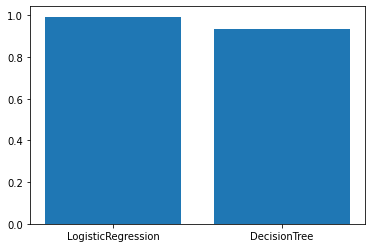

In [427]:
import matplotlib.pyplot as plt

# data = [5, 20, 15, 25, 10]
labels = ['LogisticRegression', 'DecisionTree']
plt.bar(range(len(mydata)), mydata, tick_label=labels)
plt.show()

In [428]:
print('----------kmean-------\n\n\n\n\n\n\n\n')

----------kmean-------










In [406]:
from pyspark.ml.feature import VectorAssembler
# assemble=VectorAssembler(inputCols=[
#  'x',
#  'y',
#  'z',
#  'myunion'], outputCol='features')
# assembled_data=assemble.transform(df)
assembled_data = df
assembled_data.show(2)

+-----+--------------------+-------------------+-------------------+-------------------+-------+
|label|            features|                  x|                  y|                  z|myunion|
+-----+--------------------+-------------------+-------------------+-------------------+-------+
|  1.0|(1654,[59,716,158...| 0.8426366843931521|0.38626007182305955|  2.728782926636305|      1|
|  0.0|(1654,[351,1096,1...|0.07233108156807222| 0.7212666880629572|0.10436794434214747|      0|
+-----+--------------------+-------------------+-------------------+-------------------+-------+
only showing top 2 rows



In [410]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)


+-----+--------------------+-------------------+-------------------+-------------------+-------+--------------------+
|label|            features|                  x|                  y|                  z|myunion|        standardized|
+-----+--------------------+-------------------+-------------------+-------------------+-------+--------------------+
|  1.0|(1654,[59,716,158...| 0.8426366843931521|0.38626007182305955|  2.728782926636305|      1|(1654,[59,716,158...|
|  0.0|(1654,[351,1096,1...|0.07233108156807222| 0.7212666880629572|0.10436794434214747|      0|(1654,[351,1096,1...|
+-----+--------------------+-------------------+-------------------+-------------------+-------+--------------------+
only showing top 2 rows



In [412]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,5):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    print('location of the centroids=',KMeans_fit.clusterCenters() )
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("K of clusters=",i,'-'*20,"Silhouette Score:",score)

location of the centroids= [array([ 0.04267889,  0.04267889,  0.04267889, ..., -0.06168474,
        0.62812461,  0.77179382]), array([ 0.        ,  0.        ,  0.        , ..., -1.37694208,
        0.61481814,  2.9580948 ])]
K of clusters= 2 -------------------- Silhouette Score: 0.00441132766260338
location of the centroids= [array([ 0.        ,  0.        ,  0.        , ..., -0.24610704,
        1.68402685,  1.4790474 ]), array([ 0.        ,  0.        ,  0.        , ..., -0.20691636,
        0.3190635 ,  2.9580948 ]), array([ 0.04291296,  0.04291296,  0.04291296, ..., -0.06288392,
        0.6253696 ,  0.76521099])]
K of clusters= 3 -------------------- Silhouette Score: 0.000552762866400319
location of the centroids= [array([ 0.04330884,  0.04330884,  0.04330884, ..., -0.06839184,
        0.63937127,  0.78864335]), array([ 0.        ,  0.        ,  0.        , ...,  0.74223186,
       -0.41218446,  0.        ]), array([0.        , 0.        , 0.        , ..., 0.569986  , 0.19845867

Text(0, 0.5, 'cost')

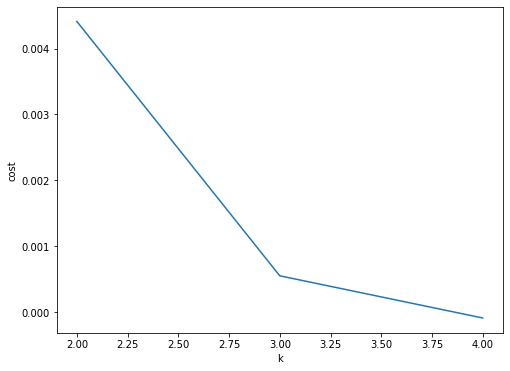

In [413]:
#Visualizing the silhouette scores in KMeans
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,5),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')